In [1]:
# Base numerical operations
import numpy as np

# Plotting
try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError: 
    !pip install matplotlib==3.4.2
    import matplotlib.pyplot as plt
%matplotlib inline

# Encoder and Decoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Data Set
import os
import glob

# Data handling and plotting
# In the current version of CMLR skimage is not installed
try:
    from skimage import io
except ModuleNotFoundError:
    !pip install scikit-image
    from skimage import io
    
from torch.utils.data import Dataset

# Dataloading and augmentation
# In the current version of CMLR torchvision is not installed
try:
    import torchvision 
except ModuleNotFoundError: 
    !pip install torchvision==0.10.0
    import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


# PyTorch Lightning
# In the current version of CMLR pytorch_lightning is not installed

try:
    import pytorch_lightning as pl
except ModuleNotFoundError: 
    !pip install pytorch-lightning==1.3.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Setup tensorboard logging
from pytorch_lightning.loggers import TensorBoardLogger

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom Datasets

### Sanity Dataset

The sanity dataset is used to check the functionality of the autoencoder. It creats `nr_samples` many zero numpy matrixes of `width` and `height` width a square box of onces of size `object_size` x `object_size`.

In [3]:
class CMLRSanityDataset(Dataset):
    def __init__(self, nr_samples, width, height, object_size, single_channel= True, transform=None):
        """ Initializes the dataset.
        
            Args:
                nr_samples: Number of samples that should be created
                width: width that the sample should have
                height: height that the sample should have
                object_size: size of the artefact that is to be displayed in each sample (square withe box)
                single_channel: if true, the sample will be of dim [1, widht, height]
                transform: a pytorch transform compose
        """
        self.nr_samples = nr_samples 
        self.width = width
        self.height = height
        self.object_size = object_size
        self.transform = transform
        self.rows = np.random.randint(low=0, high=self.width-object_size, size=(nr_samples))
        self.cols = np.random.randint(low=0, high=self.width-object_size, size=(nr_samples))
        self.single_channel = single_channel
        
    def __getitem__(self, i):
        img = np.zeros((self.width, self.height))
        img[self.cols[i]:self.cols[i]+self.object_size, self.rows[i]:self.rows[i]+self.object_size] = np.ones((self.object_size, self.object_size))
        if self.single_channel:
            x = torch.tensor(img).unsqueeze(0)
        else:
            x = np.dstack((img,img,img))
            x = torch.tensor(img).permute(2, 0, 1)
        if self.transform:
            x = self.transform(x)
        return x
        
    def __len__(self):
        #return self.len
        return self.rows.shape[0]

### Base Dataset

The basic image dataset. Reads the image data from the provided .pi file and applies the transformations.

In [4]:
class CMLRPiDataset(Dataset):
    def __init__(self, root_dir, data_pi_name, transform=None):
        """ Initializes the dataset.
        
            Args:
                root_dir: path to root directory
                data_pi_name: name of the .pi data file
                mask_pi_name: name of the .pi masking file - image used to mask out the background
        """
        
        # set class variables
        self.transform = transform
        
        # retrive training images
        trainings_data = torch.load(os.path.join(root_dir, data_pi_name))
        self.data = [img for img, label in trainings_data]
    
    def __getitem__(self, index):        
        # permute for transform operations
        x = self.data[index].permute(2, 0, 1)
        if self.transform:
            x = self.transform(x)
        return x
        
    def __len__(self):
        #return self.len
        return len(self.data)

# Custome Transformations

Custom transformations classes that can be applied to the datasets as part of pytorch's `transform.compose[()]`.

In [5]:
class AddGaussianNoise(object):
    # Adds Gaussian Noise to a sample.
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        noise_min = torch.min(noise)
        tensor = tensor + noise
        tensor[tensor >= 1.0-noise_min] = 1.0
        tensor[tensor < 0.] = 0
        return tensor
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

### Utility functions


In [6]:
# Utility functions
def inverse_normalize(tensor, mean, std):
    """ Reverses the image normalization introduced by pytorch transforms.Normalize(mean, std)
    
        Args:
            tensor: the image to be denormalized
            mean: The mean value
            std: 1/sdt value
    """
    if isinstance(mean, float) and isinstance(std, float):
        tensor.mul_(std).add_(mean)
    else:
        for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)
    return tensor

def get_train_images(num, dataset):
    """ Retrives num many images from the dataset. The data set is randomized.
        However, the image retrivel is index based and therefore will allways return the same image for given seed.
    """
    return torch.stack([dataset.dataset[i] for i in range(num)], dim=0)

# helper function to un-normalize and display an image
def imshow(img, mean, std):
    """ Denormalize and plot image 
    
        Args:
            img: the image to be denormalized
            mean: The mean value
            std: 1/sdt value
    
    """
    img = inverse_normalize(tensor=img, mean=mean, std=std)
    plt.imshow(img)#.permute(1, 2, 0) )  # convert from Tensor image

def compare_imgs(img1, img2, title_prefix=""):
    """ Calculates the loss between to images and plots them side by side
    
        Args:
            img1: first image
            img2: second image
            title_prefix: title prefix
    
    """
    # Calculate MSE loss between both images
    loss = F.mse_loss(img1, img2, reduction="sum")
    # Plot images for visual comparison
    grid = torchvision.utils.make_grid(torch.stack([img1, img2], dim=0), nrow=2, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4,2))
    plt.title("%s Loss: %4.2f" % (title_prefix, loss.item()))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()


### Setup and Configurations

In [7]:
# number of workers for the dataloader
num_workers = 0

# batch size
batch_size = 32

# width and height of the imput data
width = 64
height = 64

# number of channels of the input data
nr_channels = 1

# setting used by the normalization transform function
if nr_channels == 1: 
    mean=0.5
    std=0.5
else:
    mean=(0.5, 0.5, 0.5)
    std=(0.5, 0.5, 0.5)


# Data tranformations
transform = transforms.Compose([
    transforms.ToPILImage(),                                          # convert to PIL image
    #transforms.CenterCrop((100,100)),                                # make sure only the table surface is visible
    transforms.Resize((width, height), interpolation=torchvision.transforms.InterpolationMode.NEAREST), # adjust the image size                          # resize the image
    transforms.Grayscale(num_output_channels=nr_channels),            # adjust number of channels
    transforms.ToTensor(),                                            # convert to torch tensor
    #transforms.RandomHorizontalFlip(p=0.5),                          # randomly flip images to increase the variation of the data
    #transforms.RandomVerticalFlip(p=0.5),
    #transforms.RandomErasing(p=0.9, scale=(0.008, 0.008), ratio=(1.0, 1.0), value=0.15), # add cylinder like artifacts to the images
    #transforms.RandomErasing(p=0.9, scale=(0.005, 0.008), ratio=(1.0, 1.0), value=0.2), 
    #AddGaussianNoise(0.0, 0.2),                                      # add gaussian noise to the images to reduce the impact of the background
    transforms.Normalize(mean, std)                                   # normalize the images
])

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../image_processing/data/"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/saved_models/"

# Setting the seed - make sure that the results are reproducibil
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

Global seed set to 42


In [8]:
# create the dataset
dataset = CMLRPiDataset(
    root_dir=DATASET_PATH,
    data_pi_name ='training_data.pt',
    transform=transform
)

# To test the functionality of the autoencoder simple uncomment the dataset below
'''
dataset = CMLRSanityDataset(
        3000,
        64,
        64,
        15,
        single_channel=True,
        transform=transform
    )
'''

# retrive the number of samples in the dataset 
dataset_len = dataset.__len__()


# split the dataset in test train and valdatuion
train_set, test_set, val_set = torch.utils.data.random_split(dataset, [int(dataset.__len__()*0.7), 
                                                                       int(dataset.__len__()*0.2), 
                                                                       (dataset.__len__()-int(dataset.__len__()*0.9))])

# definition of the corresponding data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=num_workers)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)


## Visualize the data

### Sample images

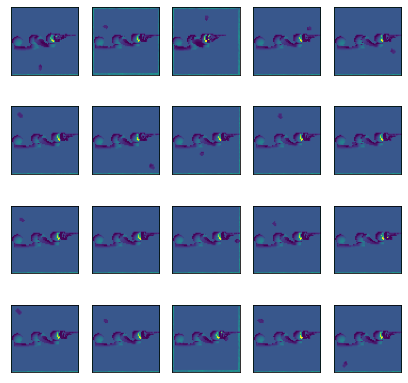

In [9]:
# obtain one batch of training images
dataiter = iter(train_loader)
images = dataiter.next()

fig = plt.figure(figsize=(7, 7))

# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx].permute(1,2,0), std, std)

### Similarity test based on MSE loss

This test helps to evaluate which loss function should be used. 

/usr/local/lib/python3.8/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


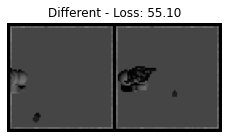

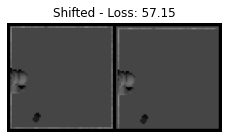

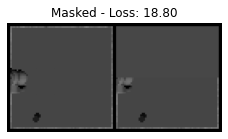

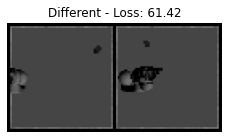

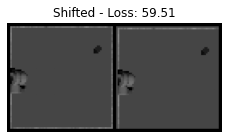

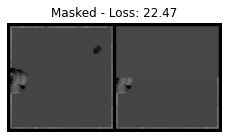

In [10]:
for i in range(2):
    # Load example image
    
    img1 = dataset[i]
    img2 = dataset[i+10]
    compare_imgs(img1, img2, "Different -")
    
    img = dataset[i]
    img_mean = img.mean(dim=[1,2], keepdims=True)
    # Shift image by one pixel
    SHIFT = 1
    img_shifted = torch.roll(img, shifts=SHIFT, dims=1)
    img_shifted = torch.roll(img_shifted, shifts=SHIFT, dims=2)
    img_shifted[:,:1,:] = img_mean
    img_shifted[:,:,:1] = img_mean
    compare_imgs(img, img_shifted, "Shifted -")

    # Set half of the image to zero
    img_masked = img.clone()
    img_masked[:,:img_masked.shape[1]//2,:] = img_mean
    compare_imgs(img, img_masked, "Masked -")

## CNN Model

### Encoder

In [11]:
class Encoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of input channels of the image. 
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        # Setup squential encoder
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, 3, padding=1), # 32x32 => 32x32
            act_fn(),
            nn.MaxPool2d(2, 2), # 32x32 => 16x16 
            nn.Conv2d(c_hid, c_hid*2, 3, padding=1), # 16x16 => 16x16
            act_fn(),
            nn.MaxPool2d(2, 2), # 16x16 => 8x8 
            nn.Conv2d(c_hid*2, c_hid, 3, padding=1), # 8x8 => 8x8
            act_fn(),
            nn.MaxPool2d(2, 2), # 4x4 => 4x4 
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(8*8*c_hid, latent_dim)
        )
    
    def forward(self, x):
        return self.net(x)

### Decoder

In [12]:
class Decoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 act_fn : object = nn.ReLU):
        """
        Inputs: 
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 8*8*c_hid),# 64 x 64
            act_fn()
        )
        # Setup squential decoder
        self.net = nn.Sequential(
            nn.ConvTranspose2d(c_hid, c_hid*2, 2, stride=2),
            act_fn(),
            nn.ConvTranspose2d(c_hid*2, c_hid, 2, stride=2),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, 2, stride=2),
            nn.Sigmoid() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )
    
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 8, 8) # 64 x 64
        x = self.net(x)
        return x

In [13]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.1)

### Autoencoder

In [14]:
class Autoencoder(pl.LightningModule):
    
    def __init__(self, 
                 base_channel_size: int, 
                 latent_dim: int, 
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = nr_channels, 
                 width: int = 64, 
                 height: int = 64):
        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters() 
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.encoder.apply(weights_init)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder.apply(weights_init)
        
        
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)
        
        self.l1_loss = torch.nn.L1Loss()#'reduction='sum')
        
    def forward(self, x):
        """
        The forward function takes in an image and returns the reconstructed image
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    
    def _get_reconstruction_loss(self, batch):
        """
        Given a batch of images, this function returns the reconstruction loss (MSE in our case)
        """
        x = batch # We do not need the labels only the images
        x_hat = self.forward(x)
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = torch.nn.functional.huber_loss(x, x_hat, reduction='none', delta=0.01)
        loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
        #loss = self.l1_loss(x, x_hat) # uncomment this line and comment out the previous three lines to use l1 loss
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=8e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                         mode='min', 
                                                         factor=0.1, 
                                                         patience=10, 
                                                         min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
    
    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch) 
        # Add the trainings loss to tensoboard via the logger
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        # Add the validation loss to tensoboard via the logger
        self.log('val_loss', loss)
    
    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        # Add the test loss to tensoboard via the logger
        self.log('test_loss', loss)
        
    def feature_extraction(self, x):
        return self.encoder(x)

In [15]:
class GenerateCallback(pl.Callback):
    
    def __init__(self, input_imgs, every_n_epochs=1):
        super().__init__()
        self.input_imgs = input_imgs # Images to reconstruct during training
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)
        
    def on_epoch_end(self, trainer, pl_module):
        """ 
        Reconstruct image and campare against original
        This hock is called every time a epoch ends it is activated every nth epoch.
        """
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct images
            input_imgs = self.input_imgs.to(pl_module.device)
            with torch.no_grad():
                pl_module.eval()
                reconst_imgs = pl_module(input_imgs)
                pl_module.train()
            # Plot and add to tensorboard
            imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
            grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True, range=(-1,1))
            # Using the logger of the trainer to add the reconstructed image to the tensorboard
            trainer.logger.experiment.add_image("Reconstructions", grid, global_step=trainer.global_step)
            # Output current reconstruction
            #compare_imgs(imgs[0], imgs[1], "Different -")

In [16]:
def train_cmlr(latent_dim):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "cmlr_%i" % latent_dim), 
                         #accumulate_grad_batches=32,
                         gpus=0, 
                         max_epochs=200, 
                         logger=logger,
                         # Save the model weights, reconstruct image every 10th epoch, logge the LR every epoch 
                         callbacks=[ModelCheckpoint(save_weights_only=True, verbose=False, dirpath=os.path.join(CHECKPOINT_PATH, "cmlr_%i" % latent_dim)),
                                    GenerateCallback(get_train_images(10,test_loader), every_n_epochs=5),
                                    LearningRateMonitor("epoch")])
    # If True, we plot the computation graph in tensorboard
    trainer.logger._log_graph = True         
    # Optional logging argument that we don't need
    trainer.logger._default_hp_metric = None 
    
    # Check whether pretrained model exists. If yes, load it and skip training
    saved_models = os.path.join(CHECKPOINT_PATH, "cmlr_%i" % latent_dim)
    if len(sorted(glob.glob(os.path.join(saved_models, '*.ckpt')))) > 0:
        pretrained_filename=sorted(glob.glob(os.path.join(saved_models, '*.ckpt')))[0]    
    else:
        pretrained_filename=" "
    
    #if os.path.isfile(pretrained_filename):
    #    print("Found pretrained model, loading...")
    #    model = Autoencoder.load_from_checkpoint(pretrained_filename)
    #else:
    model = Autoencoder(base_channel_size=32, latent_dim=latent_dim, width=width, height=height) # for 64x64 base_channel_size=32
    print(model)
    trainer.fit(model, train_loader, val_loader)
    # Test best model on validation and test set
    val_result = trainer.test(model, test_dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, test_dataloaders=test_loader, verbose=False)
    result = {"test": test_result, "val": val_result}
    return model, result

In [ ]:
model_dict = {}
for latent_dim in [16,32]:
    logger = TensorBoardLogger("tb_logs", name="cmlr_autoencoder_ld_{}".format(latent_dim))
    model_ld, result_ld = train_cmlr(latent_dim)
    model_dict[latent_dim] = {"model": model_ld, "result": result_ld}

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Autoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GELU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): GELU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): GELU()
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=2048, out_features=16, bias=True)
    )
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0): Linear(in_features=16, out_features=2048, bias=True)
      (1): ReLU()
    )
    (net): Sequential(
      (0): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
      (1): ReLU()
      (2): ConvTranspose2d(64, 32,


  | Name    | Type    | Params | In sizes       | Out sizes     
----------------------------------------------------------------------
0 | encoder | Encoder | 70.1 K | [2, 1, 64, 64] | [2, 16]       
1 | decoder | Decoder | 51.4 K | [2, 16]        | [2, 1, 64, 64]
2 | l1_loss | L1Loss  | 0      | ?              | ?             
----------------------------------------------------------------------
121 K     Trainable params
0         Non-trainable params
121 K     Total params
0.486     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

## Extract Latten Space Representation

In [ ]:
ls_dim = 16
saved_models = os.path.join(CHECKPOINT_PATH, "cmlr_%i" % latent_dim)
path=sorted(glob.glob(os.path.join(saved_models, '*.ckpt')))[0]   

if os.path.isfile(path):
    print("Found pretrained model, loading...")
    model = Autoencoder.load_from_checkpoint(path)
    model.freeze()
    
    dataiter = iter(train_loader)
    images = dataiter.next()

    x = model.feature_extraction(images)
    print(x.shape)
else:
    print("Did not find the model")

## Validate the Models

In [ ]:
# Plot the reconstruction score against the latten space dimension for the different models
latent_dims = sorted([k for k in model_dict])
val_scores = [model_dict[k]["result"]["val"][0]["test_loss"] for k in latent_dims]

fig = plt.figure(figsize=(6,4))
plt.plot(latent_dims, val_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(latent_dims, labels=latent_dims)
plt.title("Reconstruction error over latent dimensionality", fontsize=14)
plt.xlabel("Latent dimensionality")
plt.ylabel("Reconstruction error")
plt.minorticks_off()
plt.ylim(0,10)
plt.show()

In [ ]:
def visualize_reconstructions(model, input_imgs):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(model.device))
    reconst_imgs = reconst_imgs.cpu()
    
    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(7,4.5))
    plt.title("Reconstructed from %i latents" % (model.hparams.latent_dim))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [ ]:
input_imgs = get_train_images(4, test_loader)
for latent_dim in model_dict:
    visualize_reconstructions(model_dict[latent_dim]["model"], input_imgs)

# Ergebnisse

- image_dim: 64x64
- latten_dim: 32
- base_channel_size: 32
- initialization: xavia
- transformation: 2 x crop square
- LR schedular:
-- factor: 0.1 
-- patience: 10 
-- min_lr:5e-5
- loss: MSE


No change after 60 Epochs (loss at about 3.1 for 30 epochs).
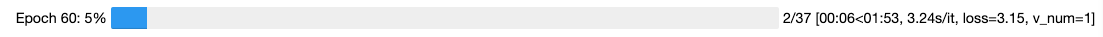
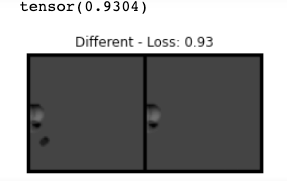